# **Background and introduction**

Data link:
https://www.kaggle.com/datasets/asinow/laptop-price-dataset/versions/1?resource=download



This dataset consists of 11,768 observations and 9 features including laptop price which is our target variable. The 8 predictors consist of GPU, processor, storage, resolution, weight, battery life, brand, and operating system. We will implement a regression model that predicts laptop prices from these specs.

# **Preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import sys
import warnings
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
import statsmodels.stats.diagnostic as sm_diagnostic
import scipy.stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.stats.outliers_influence import variance_inflation_factor



warnings.filterwarnings('ignore')
df=pd.read_csv('LaptopPrices.csv')

SDD=(df['Storage']!='1TB HDD').astype(int) # Binary feature using 1 to represent SDD and 0 to represent HDD

df['GPU'] = df['GPU'].replace({ # Ranking the GPUs by performance
    'Integrated': 1,
    'Nvidia GTX 1650': 2,
    'Nvidia RTX 2060': 3,
    'AMD Radeon RX 6600': 4,
    'Nvidia RTX 3060': 5,
    'AMD Radeon RX 6800': 6,
    'Nvidia RTX 3080': 7
})


df['Resolution']=df['Resolution'].replace({ # The magnitude of the resolution is captured by the raw # of pixels: That is, we multiply the dimensions of the pixels
    '1366x768': 1366*768,
    '2560x1440': 2560*1440,
    '1920x1080': 1920*1080,
    '3840x2160': 3840*2160
    })


df['Storage']=df['Storage'].replace({  # Express storage in terms of GB
    '256GB SSD': 256,
    '512GB SSD': 512,
    '1TB SSD': 1024,
    '1TB HDD': 1024,
    '2TB SSD': 2048
    })

df['Processor']=df['Processor'].replace({ # Rank processors by performance
    'Intel i3': 1,
    'AMD Ryzen 3': 1,
    'Intel i5': 2,
    'AMD Ryzen 5': 2,
    'Intel i7': 3,
    'AMD Ryzen 7': 3,
    'Intel i9': 4,
    'AMD Ryzen 9': 4
    })


df['Acer']=df['Brand'].apply(lambda x: 1 if x=='Acer' else 0)
df['Asus']=df['Brand'].apply(lambda x: 1 if x=='Asus' else 0)
df['Dell']=df['Brand'].apply(lambda x: 1 if x=='Dell' else 0)
df['Razer']=df['Brand'].apply(lambda x: 1 if x=='Razer' else 0)
df['MSI']=df['Brand'].apply(lambda x: 1 if x=='MSI' else 0)
df['Lenovo']=df['Brand'].apply(lambda x: 1 if x=='Lenovo' else 0)
df['Microsoft']=df['Brand'].apply(lambda x: 1 if x=='Microsoft' else 0)
df['HP']=df['Brand'].apply(lambda x: 1 if x=='HP' else 0)
df['Samsung']=df['Brand'].apply(lambda x: 1 if x=='Samsung' else 0)


df['Linux']=df['Operating System'].apply(lambda x: 1 if 'Linux' in x else 0)
df['Windows']=df['Operating System'].apply(lambda x: 1 if 'Windows' in x else 0)
df['macOS']=df['Operating System'].apply(lambda x: 1 if 'macOS' in x else 0)

df=df.drop(columns=['Brand'])
df=df.drop(columns=['Operating System'])

print(df.head(5))
print(df.shape)


   Processor  RAM (GB)  Storage  GPU  Screen Size (inch)  Resolution  \
0          1        64      512    2                17.3     3686400   
1          3         4     1024    7                14.0     1049088   
2          2        32     2048    5                13.3     8294400   
3          2         4      256    7                13.3     1049088   
4          1         4      256    4                16.0     8294400   

   Battery Life (hours)  Weight (kg)  Price ($)  Acer  ...  Dell  Razer  MSI  \
0                   8.9         1.42    3997.07     0  ...     0      0    0   
1                   9.4         2.57    1355.78     0  ...     0      1    0   
2                   8.5         1.74    2673.07     0  ...     0      0    0   
3                  10.5         3.10     751.17     0  ...     0      0    0   
4                   5.7         3.38    2059.83     0  ...     0      1    0   

   Lenovo  Microsoft  HP  Samsung  Linux  Windows  macOS  
0       0          0   0   

# **Feature Engineering. Interactions? Polynomials?**

We should be careful to not create polynomial terms for our features. They are not continuous values, and the values don't range very far, so the correlation between a feature and itself taken to a higher degree will be high. Raising its degree won't result in strong enough non-linear gain. We would have multicollinearity problems and we wouldn't significantly be adding any new information. This same logic also applies to interaction terms. That is, the non-linear effect of interactions will also be minimal.

# **Addressing extreme and missing values**

There are no missing values to address.

Extreme values will be removed using a z-score criteria. Any observations whose z-score is 4 or greater will be removed. This is more conservative than the traditional z-score of 3, but using lower z-scores results in a singular matrix and numerical instability.

Next, we remove laptops below the luxury range. These laptops are very few, and contribute variance disproportionately. Laptops whose price is below $3000 will be retained.

Both of these steps are implemented for the sake of clamping down on model variance and creating the best prediction intervals we can.

Text(0, 0.5, 'Frequency')

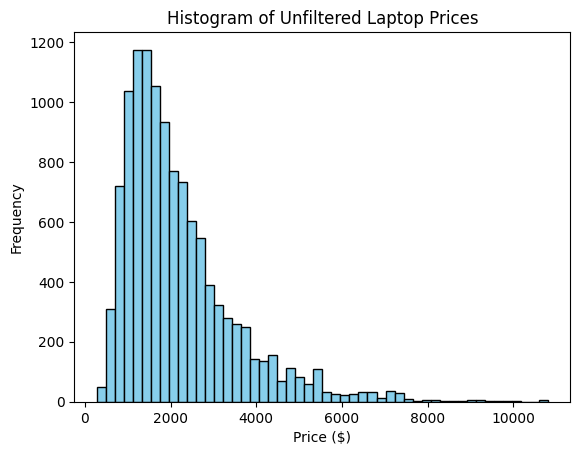

In [250]:
plt.hist(df['Price ($)'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Unfiltered Laptop Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

Implementing filtration

In [251]:

df=df[df['Price ($)']<3000]

mu=df.mean()
sigma=df.std()

df=df[abs(df-mu)/sigma<4]
df=df.dropna()
n=len(df)
print("Remaining observations:", n)

Remaining observations: 9462


# **Defining and generating the regression model**

**Note**: Normalization will only be applied to the data for inspecting multicollinearity. This project implements OLS which is scale-invariant anyway. For the sake of simplicity of model implementation, the model will be trained on denormalized data

In [252]:

y=df['Price ($)']
X=df.drop(columns=['Price ($)'])
model=LinearRegression()

# **Verifying and assuring regression assumptions are met.**

Or VIF values are all below 4, and our condition number is below 5. There is no practical level of multicollinearity to worry about.


In [253]:
df=df.dropna()

X_normed=(X-X.mean())/X.std()
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_normed.values, i) for i in range(X_normed.shape[1])]
vif['variable'] = X_normed.columns

print(vif)

cond_number = np.linalg.cond(X_normed.values)
print(f"Condition number: {cond_number:.2f}")


         VIF              variable
0   1.055766             Processor
1   1.094142              RAM (GB)
2   1.003808               Storage
3   1.004914                   GPU
4   1.003804    Screen Size (inch)
5   1.060783            Resolution
6   1.002213  Battery Life (hours)
7   1.001817           Weight (kg)
8   2.004423                  Acer
9   2.021300                  Asus
10  2.000739                  Dell
11  1.810443                 Razer
12  1.867729                   MSI
13  1.994383                Lenovo
14  2.002842             Microsoft
15  2.033894                    HP
16  2.005205               Samsung
17  1.502610                 Linux
18  1.502974               Windows
19  1.497013                 macOS
Condition number: 3.76


We apply a transformation to y in the cell below to ensure homoscedasticity.
$$y_{new}=\sqrt{y}$$

If you comment this cell (code) out, you will see a clear funneling in the residuals versus fitted values graph in further cells.


In [254]:
y=y**0.5


Get the residuals and predictions for residual analysis.

In [255]:
X=sm.add_constant(X)
model.fit(X,y)
predictions=model.predict(X)
residuals=y-predictions

The cell below shows that there is no significant autocorrelation, as 2 is contained in the 95% confidence interval of the Durbin-Watson statistic.

A note on how this confidence interval was produced:

Our sample size is uncommonly massive (N=9,462), and we know that the Durbin-Watson statistic is asymptotically normal. That is,

$$DW \xrightarrow[n \to \infty]{d} N(2,\frac{4}{n}) $$

So,

$$DW \in \hat{DW} \pm 1.96\frac{2}{\sqrt{n}}$$

In [256]:
dw=durbin_watson(residuals)
dw_err=1.96*(2/np.sqrt(n))
print("Durbin-Watson point estimate: ", dw)
print('Durbin-Watson approximate 95% confidence interval: ', [dw-dw_err, dw+dw_err])

Durbin-Watson point estimate:  2.010032120371009
Durbin-Watson approximate 95% confidence interval:  [np.float64(1.9697330901491665), np.float64(2.0503311505928514)]


The distribution of the model's residuals closely conform to a bell curve. The assumption of normality of residuals is reasonably met.

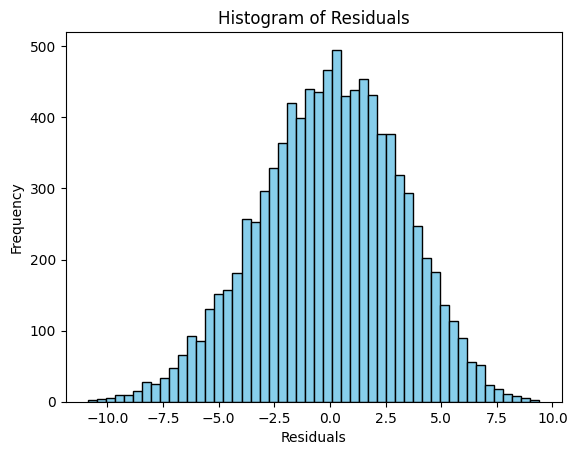

In [257]:
#color='#069AF3'
color='skyblue'

plt.hist(residuals, bins=50, color=color, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The residual variance is highly stable, satisfying the assumption of homoscedasticity. The figure below shows a dense, well rounded cloud.

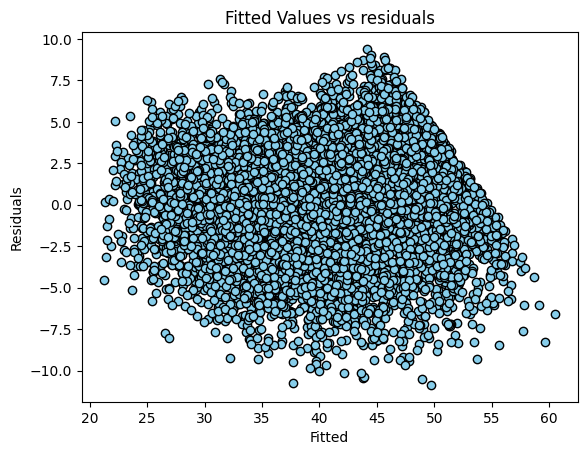

In [258]:

plt.scatter(predictions, (residuals), color=color, edgecolor='black')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title("Fitted Values vs residuals")
plt.show()

# **Cross-validation metrics**

We implement 10-fold CV on three metrics. R-squared, mean absolute error, and mean squared error. The distribution of these scores will be examined via a histogram.

In [259]:

def performance_analysis(model,X,y):

  metrics=['r2','neg_mean_absolute_error', 'neg_mean_squared_error']

  for metric in metrics:

    scores = cross_val_score(model, X, y, cv=10, scoring=metric)
    mean=np.mean(scores)
    std=np.std(scores)
    plt.hist(scores, color=color, bins=5, edgecolor='black')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.title('Histogram of 10-fold '+metric)
    plt.axvline(np.mean(scores), color='red', linestyle='solid', label=f'Mean = {mean:.3f}')
    plt.legend()
    plt.show()



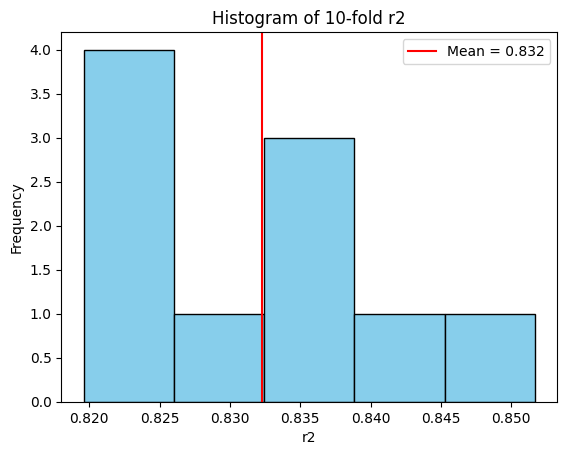

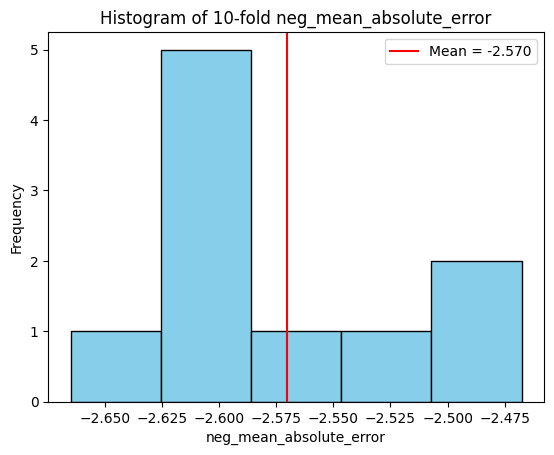

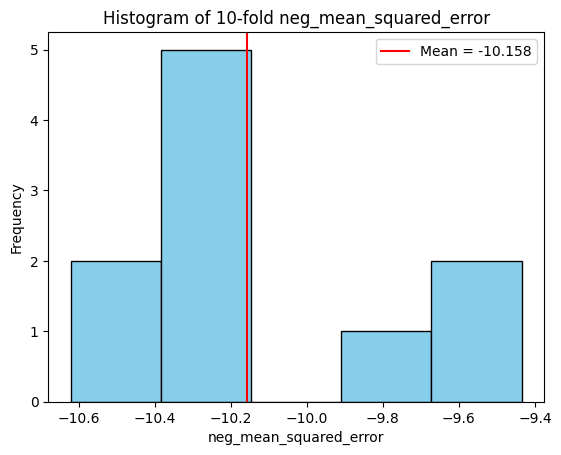

In [260]:
performance_analysis(model,X,y)

# **Estimation of coefficients and feature pruning**

Here we have the 95% confidence intervals for the coefficients of the model.


In [261]:
model=sm.OLS(y,X).fit()
model.conf_int(alpha=0.05, cols=None)

,0,1
const,12.661759,14.332362
Processor,3.996682,4.117502
RAM (GB),0.294193,0.301602
Storage,-0.000136,0.000073
GPU,0.766996,0.830480
Screen Size (inch),0.503777,0.593035
Resolution,0.000002,0.000002
Battery Life (hours),-0.027204,0.028521
Weight (kg),-0.119097,0.073494
Acer,-7.504358,-6.912903


We see that the confidence intervals for weight, battery life, storage, macOS, Windows, and Linux coefficients contain zero. We remove these features from our model, re-evaluate its performance, and find that the mean 10-fold R-squared hasn't changed (83.2%). Other metrics such as the average 10-fold MAE or MSE have changed by less than a tenth.

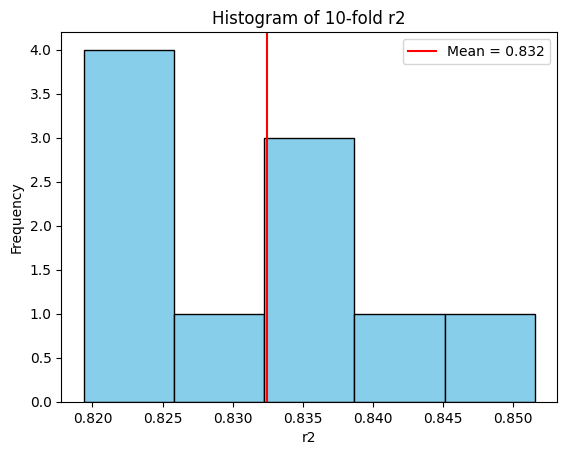

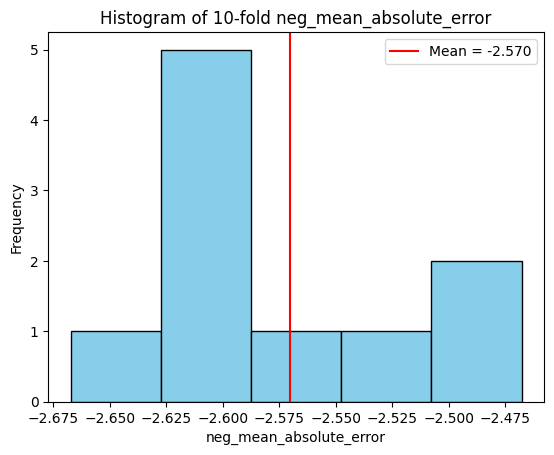

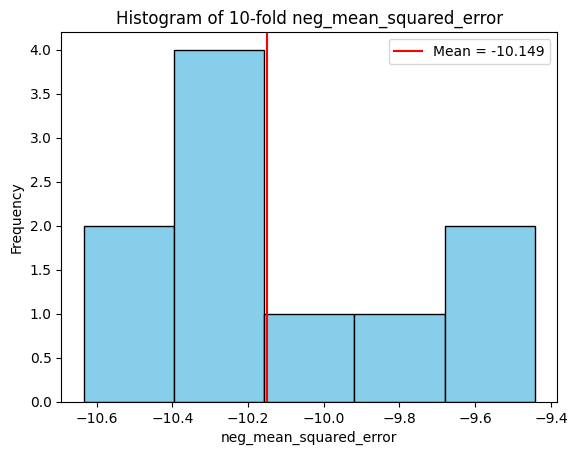

Index(['const', 'Processor', 'RAM (GB)', 'GPU', 'Screen Size (inch)',
       'Resolution', 'Acer', 'Asus', 'Dell', 'Razer', 'MSI', 'Lenovo',
       'Microsoft', 'HP', 'Samsung'],
      dtype='object')


In [262]:
X=X.drop(columns=['Weight (kg)', 'Battery Life (hours)', 'Storage', 'macOS', 'Windows', 'Linux'])
model=LinearRegression()
performance_analysis(model,X,y)
print(X.keys())

# **Analysis of predictions and prediction certainty**

Let's separate the data into training and testing. Then, let's generate predictions intervals for the observations in $X_{test}$. We will compromise on confidence level a little bit to create more practical margins of error. We will generate them at 90% confidence instead of 95% confidence. In order to get prediction intervals for the original price $y$ and not $\sqrt{y}$, we will have to square both ends of the prediction intervals.

We examine the rate at which the prediction intervals contain the true $y_{test}$, examine the distribution of the margins of error, and see how the margins of error relate to $y_{test}$.

The coverage rate of our 90% prediction intervals is 89%. The distribution of our margins of error is a bell curve with a mean of 419 and a standard deviation of 74. The margin of error and the actual $y_{test}$ are correlated. That is, the more expensive the laptop, the more uncertainty there is in our prediction. This may be due to more customization for higher end laptops, as well as more specifications.

Coverate rate: 0.8951595857112661
Average ME: 419.6594655601826
STD ME: 74.34276911126668


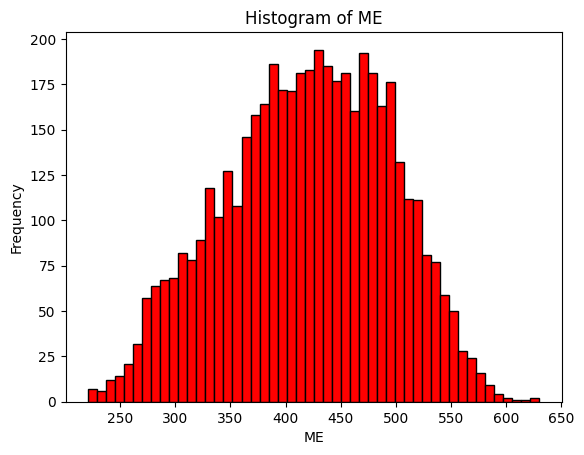

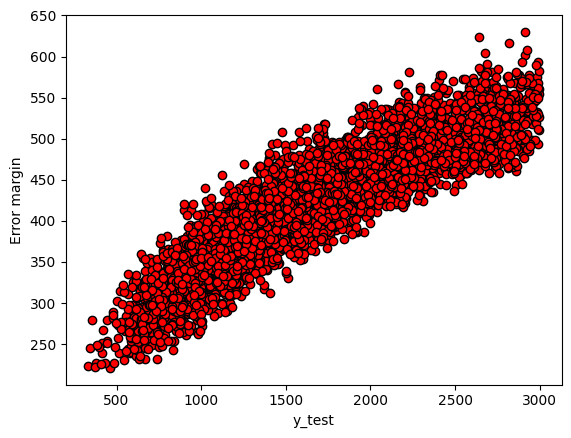

In [263]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


beta=np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

fitted=np.array(X_train) @ beta
resids=y_train-fitted

p=X_train.shape[1]
n_train=len(X_train)
MSE=np.sum(resids**2)/(n_train-p-1)

isin=[]
ME_list=[]
k=0
alpha=0.1

t_crit=scipy.stats.t.ppf(1-alpha/2,n_train-p-1)


for x in np.array(X_test):
  pt_est=x@beta
  SE=np.sqrt(MSE*(1+x.T @ np.linalg.inv(X_train.T @ X_train) @ x))
  ME=t_crit*SE

  lower=pt_est-ME
  upper=pt_est+ME
  ME_list.append((upper**2-lower**2)/2)

  if y_test.iloc[k] >= lower and y_test.iloc[k] <= upper:
    isin.append(1)
  else:
    isin.append(0)
  k+=1




print("Coverate rate:", np.sum(isin)/len(isin))
print('Average ME:', np.mean(ME_list))
print("STD ME:", np.std(ME_list))

plt.hist(ME_list,color='red',edgecolor='black',bins=50)
plt.xlabel('ME')
plt.ylabel('Frequency')
plt.title('Histogram of ME')
plt.show()

plt.scatter(y_test**2,ME_list,color='red',edgecolor='black')
plt.xlabel('y_test')
plt.ylabel('Error margin')
plt.show()

# **Model Implementation**

In [272]:
global BETA
global X_TRAIN
global MEAN_SQR_ERR

BETA=beta
X_TRAIN=X_train
MEAN_SQR_ERROR=MSE


alpha=0.05
def predict(x,alpha):
  STD_ERROR=np.sqrt(MEAN_SQR_ERROR*(1+x.T @ np.linalg.inv(X_TRAIN.T @ X_TRAIN) @ x))
  t_crit=scipy.stats.t.ppf(1-alpha/2,len(X_TRAIN)-X_TRAIN.shape[1]-1)
  lower=x@BETA-t_crit*STD_ERROR
  upper=x@BETA+t_crit*STD_ERROR
  return [lower,upper]





0     12.958380
1      4.053895
2      0.295798
3      0.801889
4      0.578882
5      0.000002
6     -7.156192
7     -7.097328
8     -7.316291
9     -1.013109
10    -2.565421
11    -6.825670
12    -7.169842
13    -7.115366
14    -6.686873
dtype: float64
